In [1]:
!pip install torch torchvision

    100% |████████████████████████████████| 484.0MB 26kB/s 
tcmalloc: large alloc 1073750016 bytes == 0x5ce98000 @  0x7fb4a499d1c4 0x46d6a4 0x5fcbcc 0x4c494d 0x54f3c4 0x553aaf 0x54e4c8 0x54f4f6 0x553aaf 0x54efc1 0x54f24d 0x553aaf 0x54efc1 0x54f24d 0x553aaf 0x54efc1 0x54f24d 0x551ee0 0x54e4c8 0x54f4f6 0x553aaf 0x54efc1 0x54f24d 0x551ee0 0x54efc1 0x54f24d 0x551ee0 0x54e4c8 0x54f4f6 0x553aaf 0x54e4c8
    100% |████████████████████████████████| 61kB 14.9MB/s 
    100% |████████████████████████████████| 2.0MB 14.0MB/s 
  Found existing installation: Pillow 4.0.0
    Uninstalling Pillow-4.0.0:
      Successfully uninstalled Pillow-4.0.0


In [0]:
import numpy as np
import torch
import torch.nn as nn
import torchvision.datasets as dsets
import torchvision.transforms as transforms

In [3]:
torch.cuda.is_available()

True

In [4]:
torch.cuda.get_device_name(0)

'Tesla K80'

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [0]:
# Hyperparameters 
num_epochs = 10
batch_size = 100
learning_rate = 0.001

In [7]:
# MNIST Dataset (Images and Labels)
train_dataset = dsets.MNIST(root='./data', 
                            train=True, 
                            transform=transforms.ToTensor(),
                            download=True)

test_dataset = dsets.MNIST(root='./data', 
                           train=False, 
                           transform=transforms.ToTensor())

# Dataset Loader (Input Pipline)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=batch_size, 
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                          batch_size=batch_size, 
                                          shuffle=False)

Processing...
Done!


In [0]:
class CNN(nn.Module):
    
    def __init__(self):
        super(CNN, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=5, padding=2),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=5, padding=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2))
        self.fc = nn.Linear(7 * 7 * 32, 10)
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out

In [0]:
model = CNN().to(device)

In [10]:
print(model)

CNN(
  (layer1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Linear(in_features=1568, out_features=10, bias=True)
)


In [11]:
# テスト
images, labels = iter(train_loader).next()
print(images.size())
images = images.to(device)
outputs = model(images)

torch.Size([100, 1, 28, 28])


In [0]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [0]:
def train(train_loader):
    model.train()
    running_loss = 0
    for batch_idx, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)

        loss = criterion(outputs, labels)
        running_loss += loss.item()

        loss.backward()
        optimizer.step()

    train_loss = running_loss / len(train_loader)
    
    return train_loss


def valid(test_loader):
    model.eval()
    running_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_idx, (images, labels) in enumerate(test_loader):
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)

            loss = criterion(outputs, labels)
            running_loss += loss.item()

            predicted = outputs.max(1, keepdim=True)[1]
            correct += predicted.eq(labels.view_as(predicted)).sum().item()
            total += labels.size(0)

    val_loss = running_loss / len(test_loader)
    val_acc = correct / total
    
    return val_loss, val_acc

In [14]:
loss_list = []
val_loss_list = []
val_acc_list = []
for epoch in range(num_epochs):
    loss = train(train_loader)
    val_loss, val_acc = valid(test_loader)

    print('epoch %d, loss: %.4f val_loss: %.4f val_acc: %.4f' % (epoch, loss, val_loss, val_acc))
    
    # logging
    loss_list.append(loss)
    val_loss_list.append(val_loss)
    val_acc_list.append(val_acc)

epoch 0, loss: 0.1760 val_loss: 0.0583 val_acc: 0.9809
epoch 1, loss: 0.0530 val_loss: 0.0472 val_acc: 0.9839
epoch 2, loss: 0.0399 val_loss: 0.0311 val_acc: 0.9887
epoch 3, loss: 0.0319 val_loss: 0.0316 val_acc: 0.9901
epoch 4, loss: 0.0266 val_loss: 0.0284 val_acc: 0.9901
epoch 5, loss: 0.0232 val_loss: 0.0348 val_acc: 0.9886
epoch 6, loss: 0.0196 val_loss: 0.0301 val_acc: 0.9898
epoch 7, loss: 0.0160 val_loss: 0.0263 val_acc: 0.9914
epoch 8, loss: 0.0133 val_loss: 0.0256 val_acc: 0.9924
epoch 9, loss: 0.0124 val_loss: 0.0287 val_acc: 0.9915


Text(0,0.5,'acc')

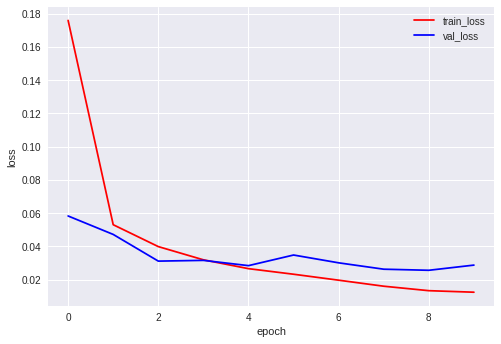

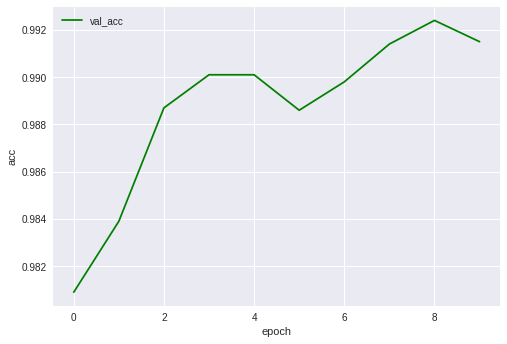

In [15]:
import numpy as np
import matplotlib.pyplot as plt

# plot learning curve
plt.figure()
plt.plot(range(num_epochs), loss_list, 'r-', label='train_loss')
plt.plot(range(num_epochs), val_loss_list, 'b-', label='val_loss')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('loss')

plt.figure()
plt.plot(range(num_epochs), val_acc_list, 'g-', label='val_acc')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('acc')